In [129]:
import pylab
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage.interpolation import geometric_transform
global origin
origin = (262,170) 

In [130]:
train_vid = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/train.mp4'
labels_file = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/train.txt'

In [143]:
file = open(labels_file, 'r') 
labels = file.read().split()
file.close()

AxesImage(54,36;334.8x217.44)
400


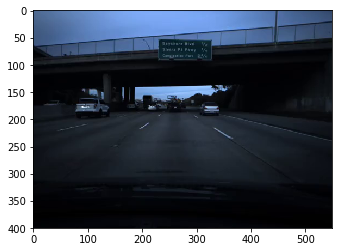

In [506]:
vid = imageio.get_reader(train_vid,  'ffmpeg')
nums = range(1000)
vid_frames = []
for num in nums:
    image = vid.get_data(num)
    vid_frames.append(image[50:450,50:600])

print(pylab.imshow(vid_frames[0]))

## Get the video dimensions
v = vid_frames[0].shape[0]
h = vid_frames[0].shape[1]
print(v)

In [507]:
def split_triplet_frames(vid_frames,labels):
    np.random.seed(2)

    ## Select random triplets: 80% train set, 20% dev set
    L = len(vid_frames)
    L = L-np.mod(L,3)
    i_split = np.random.rand(int(L/3)) 
    vidframes_train = []
    vidframes_dev = []
    labels_train = []
    labels_dev = []
    for i,ix in enumerate(i_split):
        ind_frames = i*3
        if ix < 0.8:
            vidframes_train.append(vid_frames[ind_frames])
            vidframes_train.append(vid_frames[ind_frames+1])
            vidframes_train.append(vid_frames[ind_frames+2])
            labels_train.append(labels[ind_frames])
        else:
            vidframes_dev.append(vid_frames[ind_frames])
            vidframes_dev.append(vid_frames[ind_frames+1])
            vidframes_dev.append(vid_frames[ind_frames+2])
            labels_dev.append(labels[ind_frames])
    return vidframes_train,vidframes_dev,labels_train,labels_dev

vidframes_train,vidframes_dev,labels_train,labels_dev = split_triplet_frames(vid_frames,labels)
print('Training triplets: %d  Dev triplets: %d'%(len(vidframes_train),len(vidframes_dev)))
print('Training labels: %d  Dev labels: %d'%(len(labels_train),len(labels_dev)))

Training triplets: 819  Dev triplets: 180
Training labels: 273  Dev labels: 60


In [121]:
def brightness_augment(image, offset, rand_amplitude):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    factor = offset + rand_amplitude*np.random.uniform()
    hsv_image[:,:,2] = hsv_image[:,:,2] * factor
    im = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    im = np.round(255.*im/np.max(im))
    return im.astype('uint8')


In [122]:
def opticalFlowFarneback(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """    
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    hsv = np.zeros(image_current.shape)
    hsvconv = np.ones(image_current.shape)
    
    # set saturation as saturation of current grey
    #hsvconv[:,:,1] = cv2.cvtColor(image_current, cv2.COLOR_RGB2HSV)[:,:,1]
    # set saturation as current grey
    hsv[:,:,1] = gray_current
 
    # Flow Parameters
    #flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 5 #15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] =  ang* (180/ np.pi / 2) #cv2.normalize(ang,None,0,255,cv2.NORM_MINMAX) #ang* (180/ np.pi / 2)
    hsvconv[:,:,0] =  ang* (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    hsvconv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to int32's
    hsv = np.asarray(hsv, dtype= np.float32)
    hsvconv = np.asarray(hsvconv, dtype= np.float32)
    
    rgb_flow = cv2.cvtColor(hsvconv,cv2.COLOR_HSV2RGB)

    return hsv.astype('uint8'), rgb_flow.astype('uint8')

Compute optic flow (Farneback method) on pairs of frames, and apply same algorithm to compute acceleration. Code modified to include 3 frames instead of 2, which enables the acceleration computation

In [508]:
## Brightness_augment and process
im = 7*3
fr1 = brightness_augment(vidframes_train[im+2],0.5,0.5)
fr0 = brightness_augment(vidframes_train[im+1],0.5,0.5)
frm1 = brightness_augment(vidframes_train[im],0.5,0.5)

flow, frgb = opticalFlowFarneback(fr0,fr1)
flow2, frgb2 = opticalFlowFarneback(fr0,frm1)

acc2,argb = opticalFlowFarneback(frgb, frgb2)

acc = flow2-flow

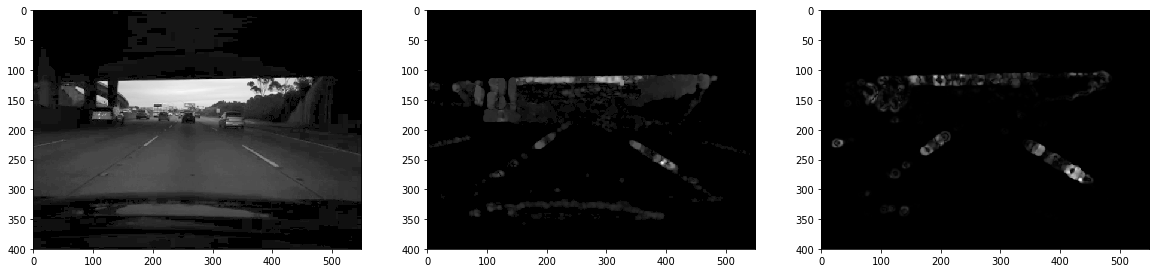

In [509]:
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.imshow(flow[:,:,1]**0.5,cmap = 'gray')
plt.subplot(132)
plt.imshow(flow2[:,:,2]**0.5,cmap = 'gray')#[:,:,2],cmap = 'gray')
plt.subplot(133)
plt.imshow(acc2[:,:,2],cmap = 'gray')#[:,:,2],cmap = 'gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


461.5668965599678


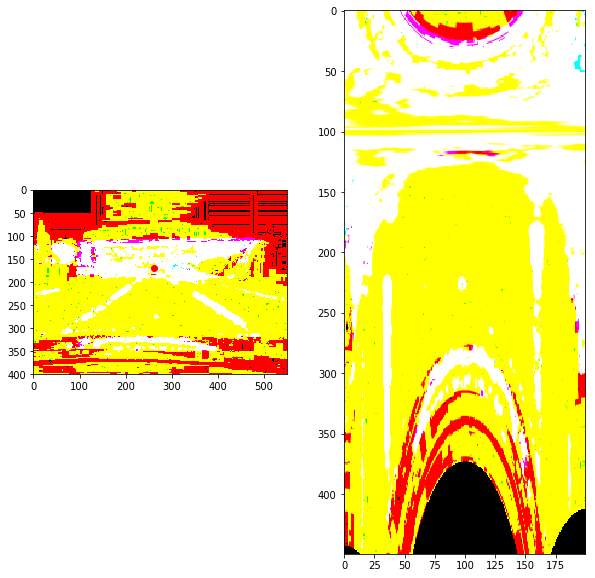

In [580]:

def img_topolar(img):
    """
    Transform img to its polar coordinate representation.

    order: int, default 1
        Specify the spline interpolation order. 
        High orders may be slow for large images.
    """        
    #(nx//2, ny//2)
    ny, nx = img.shape[:2]
    # max_radius is the length of the diagonal 
    # from a corner to the origin of img.
    max_radius = 0.5*np.linalg.norm(img.shape)
    max_radius = np.sqrt(max(nx-origin[1],origin[1])**2 + max(ny-origin[0],origin[0])**2)

    def transform(coords):
        # Put coord[1] in the interval, [-pi, pi]
        theta = 2*np.pi*coords[1] / (img.shape[0] - 1.)

        # Then map it to the interval [0, max_radius].
        #radius = float(img.shape[0]-coords[0]) / img.shape[0] * max_radius
        radius = max_radius * coords[0] / img.shape[1]

        i = origin[0] - radius*np.sin(theta) #0.5 * img.shape[0] - radius*np.sin(theta)
        j = radius*np.cos(theta) + origin[1] #radius*np.cos(theta) + 0.5 * img.shape[1]
        return i,j
    
    if img.ndim == 2:
        polar = geometric_transform(img.T, transform, order=1)
        rads = max_radius * np.linspace(0,1,img.shape[1])
        angs = np.linspace(0, 2*np.pi, img.shape[0])
        
    elif img.ndim == 3:
        polar = np.zeros((img.shape[1],img.shape[0],img.shape[2]))
        for i in range(img.shape[2]):
            polar[:,:,i] = geometric_transform(img[:,:,i].T, transform, order=1)
        rads = max_radius * np.linspace(0,1,img.shape[1])
        angs = np.linspace(0, 2*np.pi, img.shape[0])

    return polar, (rads, angs)

def concatenate_image(pol,rads,angs):
    new_L = pol[:,angs>3*np.pi/2]
    new_R = pol[:,angs<=np.pi/2]
    new_bot = np.hstack((new_L,new_R))
    new_top = pol[:,((angs>np.pi/2)*(angs<=3*np.pi/2))]
    new_im = np.vstack((new_top[::-1],new_bot))
    return new_im[450:900,:] #[:,0:int(min(rads))]

data = flow[:,:,:]**0.2
#plot_polar_image(data, origin=None)
#plot_directional_intensity(data, origin=None)
pol,(rads,angs) = img_topolar(data)
plt.figure(figsize = (10,10))

plt.subplot(121)
plt.imshow(data)
plt.plot(origin[0],origin[1],'ro')

top = concatenate_image(pol,rads,angs)
plt.subplot(122)
plt.imshow(top)

print(rads.max())

In [535]:
flow.shape[2]

3

## Section 1a concatenate the data into training and dev sets

In [411]:
def create_set_for_model(vid_in):## Create array with the image, velocity and acc 
    triplet_array = []
    
    for im in range(int(len(vid_in)/3)):
        fr1 = brightness_augment(vid_in[im+2],0.5,0.5)
        fr0 = brightness_augment(vid_in[im+1],0.5,0.5)
        frm1 = brightness_augment(vid_in[im],0.5,0.5)

        flow, frgb = opticalFlowFarneback(fr0,fr1)
        flow2, frgb2 = opticalFlowFarneback(fr0,frm1)

        acc2,argb = opticalFlowFarneback(frgb, frgb2)
       # acc = flow2-flow

        input_vec = np.stack((flow[:,:,1],flow[:,:,2],flow[:,:,0],acc2[:,:,0],acc2[:,:,2]))
       # input_vec = np.stack((flow[:,:,1], acc2[:,:,0],acc2[:,:,2]))
            
        triplet_array.append(input_vec.T)

    return np.asarray(triplet_array)

train_array = create_set_for_model(vidframes_train)
dev_array = create_set_for_model(vidframes_dev)

In [412]:
print(train_array.shape)
print(np.asarray(labels_train).shape)
print(len(vidframes_train)/3)

(273, 550, 250, 5)
(273,)
273.0


## Section 2 - making the model

In [372]:
from keras.layers import Input, Dense,MaxPooling2D,Flatten, Conv2D,BatchNormalization,Activation
from keras.models import Model
## model from the course

def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
   # X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (5, 5), strides = (2, 2), name = 'conv0')(X_input)
    X = BatchNormalization(axis = -1, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((20, 20), name='max_pool')(X)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (5, 5), strides = (2, 2), name = 'conv1')(X_input)
    X = BatchNormalization(axis = -1, name = 'bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((20, 20), name='max_pool1')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='SpeedModel')

    return model

In [373]:
#print(np.asarray(train_array).shape)
spModel = model(np.asarray(train_array[0]).shape)

In [374]:
spModel.compile(optimizer = 'adam', loss = "mean_squared_error", metrics = ['mse'])

In [396]:
history2step = spModel.fit(x = train_array, y = np.asarray(labels_train).astype('float32'), epochs = 3, batch_size = 16)


Epoch 1/3
273/273 [==============================] - 23s 84ms/step - loss: 8.6992 - mean_squared_error: 8.6992
Epoch 2/3
273/273 [==============================] - 23s 85ms/step - loss: 7.5115 - mean_squared_error: 7.5115
Epoch 3/3
273/273 [==============================] - 23s 84ms/step - loss: 6.6816 - mean_squared_error: 6.6816


In [397]:
history.model

In [398]:
preds = spModel.evaluate(x = dev_array, y = np.asarray(labels_dev).astype('float32'))

60/60 [==============================] - 2s 27ms/step


In [399]:
print(preds[1])

8.226538880666096


In [404]:
pred_speed_t = spModel.predict(x = train_array)
pred_speed_d = spModel.predict(x = dev_array)

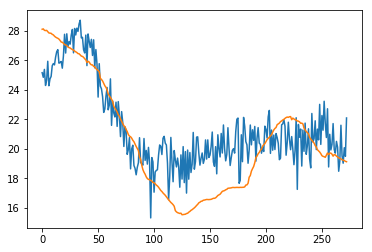

In [405]:
plt.plot(pred_speed_t)
plt.plot(np.asarray(labels_train).astype('float32'))

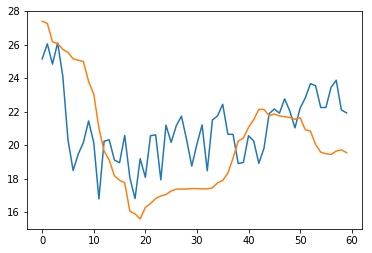

In [406]:
plt.plot(pred_speed_d)
plt.plot(np.asarray(labels_dev).astype('float32'))